In [128]:
import os
from pathlib import Path
import pandas as pd
import librosa
import librosa.display
import numpy as np
from glob import glob
from datetime import datetime
from tqdm import tqdm

from IPython.display import Audio

import torch
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns


# BASE_PATH = "/mnt/c/Users/uvb/Documents/DeepVoice/soundbay"
BASE_PATH = Path(os.getcwd())
DATASET_PATH = BASE_PATH /"datasets/fannie_project"
print(DATASET_PATH)

/mnt/d/DeepVoice/soundbay/datasets/fannie_project


# tags EDA:
I want to start with making all the tags from Fannie be in the right format and check their values.

In [130]:
# load txt files:

files = DATASET_PATH.rglob("*.txt")

# load all files and cerate a dataframe:
tag_df = pd.DataFrame()
for f in tqdm(files):
    tmp_file = pd.read_csv(f, sep="\t", on_bad_lines='skip')
    tmp_file['annotation_source'] = str(f).replace('.txt', '')
    tag_df = pd.concat([tag_df, tmp_file], axis=0)

del tmp_file
# change name of wav file to be correct:
tag_df['Begin File'] = tag_df.apply(lambda x: x["Begin File"][3:], axis=1)

# remove unnecessary columns:
tag_df = tag_df[['Begin File', 'Begin Time (s)', 'End Time (s)', 'Low Freq (Hz)', 'High Freq (Hz)', 'Peak Freq (Hz)', 'annotation_source']]

tag_df = tag_df.reset_index(drop=True)
tag_df["whale_type"] = tag_df.apply(lambda x: str(x["annotation_source"]).split('/')[-2], axis=1)
tag_df["call_duration"] = tag_df.apply(lambda x: x["End Time (s)"] - x["Begin Time (s)"], axis=1)

tag_df.head()

16it [00:00, 191.99it/s]


,Begin File,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Peak Freq (Hz),annotation_source,whale_type,call_duration
0,5756.210501212958.wav,18471.964378,18478.240523,24.036,26.831,25.195,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,ANT_BLUE,6.276145
1,5756.210502002958.wav,20207.100881,20213.879117,23.757,26.551,24.609,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,ANT_BLUE,6.778237
2,5756.210502002958.wav,20268.105012,20276.012955,23.477,26.551,25.195,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,ANT_BLUE,7.907943
3,5756.210502002958.wav,20388.958651,20399.753620,23.757,26.272,24.609,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,ANT_BLUE,10.794970
4,5756.210502002958.wav,20455.485790,20462.640595,23.477,26.551,25.195,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,ANT_BLUE,7.154806


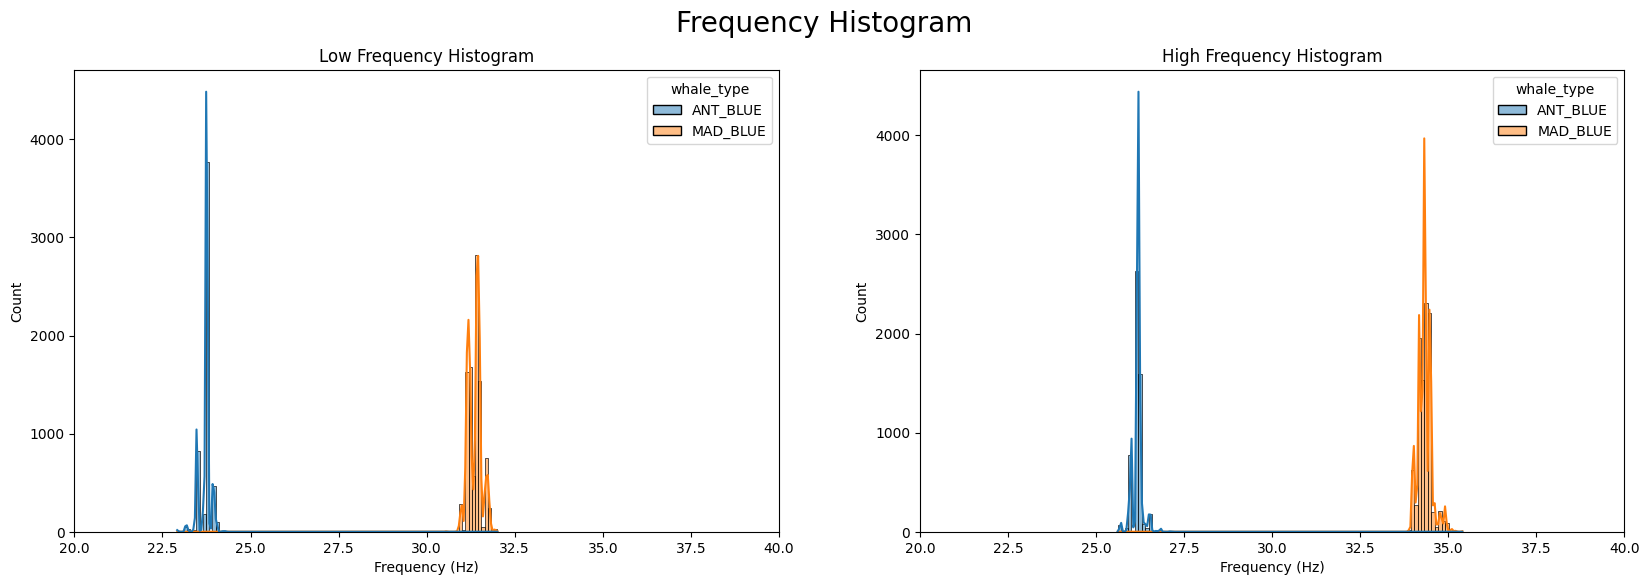

In [131]:
# create a histogram of the frequencies:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle("Frequency Histogram", fontsize=20)

sns.histplot(data = tag_df, x = 'Low Freq (Hz)', hue = "whale_type", kde=True, bins=100, ax=ax[0])
ax[0].set(title = "Low Frequency Histogram", xlabel = "Frequency (Hz)", ylabel = "Count", xlim = (20, 40))

sns.histplot(data = tag_df, x = 'High Freq (Hz)', hue = "whale_type", kde=True, bins=100, ax=ax[1])
ax[1].set(title = "High Frequency Histogram", xlabel = "Frequency (Hz)", ylabel = "Count", xlim = (20, 40))

plt.show()

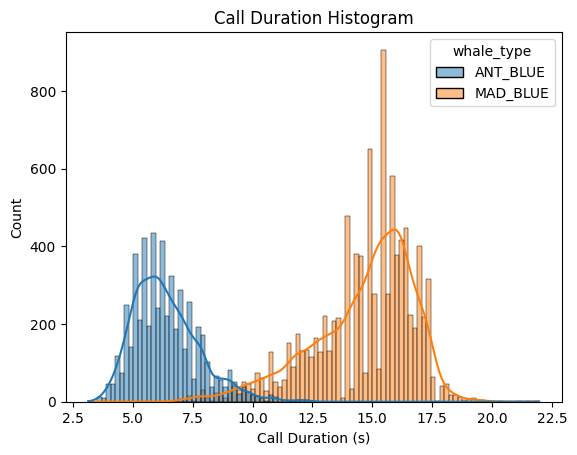

In [132]:
# call times
sns.histplot(data = tag_df, x = 'call_duration', hue = "whale_type", kde=True, bins=100)
plt.title("Call Duration Histogram")
plt.xlabel("Call Duration (s)")
plt.ylabel("Count")
plt.show()

In [133]:
# get statistics of the data:
print("Antarvtic whales:")
ant_whale_df = tag_df[tag_df['whale_type'] == 'ANT_BLUE']
ant_whale_df.describe()
# del ant_whale_df

Antarvtic whales:


,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Peak Freq (Hz),call_duration
count,5441.000000,5441.000000,5441.000000,5441.000000,5441.000000,5441.000000
mean,294259.349692,294265.735646,23.720313,26.182238,24.972167,6.385954
std,184738.201787,184738.226273,0.147687,0.132605,0.324897,1.378463
min,22.970691,32.008340,22.918000,25.616000,23.438000,3.138073
25%,117608.826609,117614.851709,23.750000,26.169000,24.609000,5.397485
50%,299265.450744,299271.977935,23.752000,26.200000,25.195000,6.150622
75%,452634.108954,452640.887191,23.757000,26.212000,25.195000,7.154806
max,624260.715564,624272.138148,24.298000,27.110000,25.781000,12.426767


In [134]:
# get statistics of the data:
print("Mad Blue whales:")
mad_whale_df = tag_df[tag_df['whale_type'] == 'MAD_BLUE']
mad_whale_df.describe()
# del mad_whale_df

Mad Blue whales:


,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Peak Freq (Hz),call_duration
count,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000
mean,281080.098509,281094.747566,31.364686,34.333791,32.922222,14.649057
std,170839.724709,170839.863810,0.188424,0.188598,0.231649,2.124295
min,3.891210,19.330527,30.554000,33.700000,31.641000,6.527191
25%,127985.212021,128001.153430,31.196000,34.200000,32.812000,13.430951
50%,265241.055730,265251.725177,31.427000,34.337000,32.812000,15.062748
75%,420876.457683,420891.959762,31.493000,34.464000,32.812000,16.192455
max,625152.589985,625164.389138,32.009000,35.400000,33.984000,21.966508


In [135]:
# clear memory:
del ant_whale_df, mad_whale_df

we also want to know in which time of the year the calls tags are:

In [136]:
tag_df['time'] = tag_df.apply(lambda x: str(x["annotation_source"]).split('/')[-1].split(".")[1], axis=1)
tag_df['time'] = tag_df.apply(lambda x: datetime.strptime(x["time"], '%y%m%d%H%M%S'), axis=1)

# add month time:
tag_df['month'] = tag_df.apply(lambda x: x["time"].month, axis=1)
tag_df['month'] = tag_df.apply(lambda x: datetime.strptime(str(x["month"]), '%m').strftime('%B'), axis=1)
tag_df.head()

,Begin File,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Peak Freq (Hz),annotation_source,whale_type,call_duration,time,month
0,5756.210501212958.wav,18471.964378,18478.240523,24.036,26.831,25.195,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,ANT_BLUE,6.276145,2021-05-01 00:29:58,May
1,5756.210502002958.wav,20207.100881,20213.879117,23.757,26.551,24.609,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,ANT_BLUE,6.778237,2021-05-01 00:29:58,May
2,5756.210502002958.wav,20268.105012,20276.012955,23.477,26.551,25.195,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,ANT_BLUE,7.907943,2021-05-01 00:29:58,May
3,5756.210502002958.wav,20388.958651,20399.753620,23.757,26.272,24.609,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,ANT_BLUE,10.794970,2021-05-01 00:29:58,May
4,5756.210502002958.wav,20455.485790,20462.640595,23.477,26.551,25.195,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,ANT_BLUE,7.154806,2021-05-01 00:29:58,May


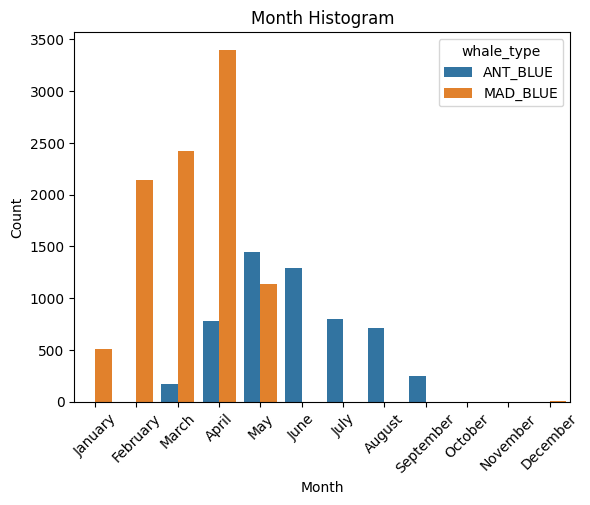

In [137]:
# Ensure the months are ordered correctly
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

sns.countplot(data=tag_df, x='month', hue='whale_type', order=month_order)
plt.title("Month Histogram")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# WAV EDA:
I want to see the calls and find the right parameters for the spectrograms

calculate the tags times:
the times in the dataframe is based on the time of all the files since the begining of the month.
For handeling that:
1. create a list of all .wav files
2. get from their names their date and time
3. sort them by their time
4. for each of the notation, check how many files in the month are before it
5. substract from the begining time of the label (# files * 14 [min] * 60)

In [145]:
files = DATASET_PATH.rglob("*.wav")

# create a dataframe with the files:
wav_df = pd.DataFrame({
    "location": [str(f) for f in files]
    })
wav_df['name'] = wav_df.apply(lambda x: str(x["location"]).split('/')[-1], axis=1)
wav_df['rec_id'] = wav_df.apply(lambda x: x["name"].split('.')[0], axis=1)

wav_df.head()

,location,name,rec_id
0,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,5756.210415182958.wav,5756
1,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,5756.210415192958.wav,5756
2,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,5756.210415202958.wav,5756
3,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,5756.210415212958.wav,5756
4,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,5756.210415222958.wav,5756


In [146]:
# check files lengths:
def get_file_length(file):
    try:
        info = torchaudio.info(file)
        length = info.num_frames / info.sample_rate
        return length
    except Exception as e:
        print(f"Error loading {file}: {e}")
        return None

In [147]:
wav_df['length'] = wav_df.apply(lambda x: get_file_length(x["location"]), axis=1)

In [148]:
wav_df['length'].describe()

count    9276.000000
mean      839.862949
std         9.878037
min        61.171000
25%       839.995000
50%       840.007000
75%       840.019000
max       840.032000
Name: length, dtype: float64

In [40]:
def remove_month_time(row, wav_df=wav_df):
    if "year" not in row:
        row['time'] = convert_file_to_time(row["Begin File"])
        row["year"] = row["time"].year
        row["month"] = row["time"].month
        row["day"] = row["time"].day
        row["hour"] = row["time"].hour
        row["minute"] = row["time"].minute
        row["second"] = row["time"].second

    # m_wav_df = wav_df[(wav_df["year"] == row["year"]) & (wav_df["month"] == row["month"]) & (wav_df["day"] <= row["day"]) & \
    #                   (wav_df["hour"] <= row["hour"]) & (wav_df["minute"] <= row["minute"]) & (wav_df["second"] <= row["second"])]
    # n_samples = m_wav_df.shape[0]
    n_samples = row["hour"] + (24 * (row["day"] - 1))
    row["Begin Time (s)"] = row["Begin Time (s)"] - (n_samples * 14 * 60)
    row["End Time (s)"] = row["End Time (s)"] - (n_samples * 14 * 60)
    row.drop(["time", "year", "month", "day", "hour", "minute", "second"], inplace=True)
    return row

df = df.apply(lambda x: remove_month_time(x), axis=1)
df.head()

,Selection,View,Channel,Begin Time (s),End Time (s),High Freq (Hz),Low Freq (Hz),Peak Freq (Hz),Delta Time (s),Dur 90% (s),SNR NIST Quick (dB),Begin File,annotation_source,name
0,1,Spectrogram 1,1,831.964378,838.240523,26.831,24.036,25.195,6.2761,5.3805,6.96,5756.210501212958.wav,LF_5756.210501002958.Table.1.selections,ANT_BLUE
1,2,Spectrogram 1,1,47.100881,53.879117,26.551,23.757,24.609,6.7782,6.0674,9.95,5756.210502002958.wav,LF_5756.210501002958.Table.1.selections,ANT_BLUE
2,3,Spectrogram 1,1,108.105012,116.012955,26.551,23.477,25.195,7.9079,5.9529,11.75,5756.210502002958.wav,LF_5756.210501002958.Table.1.selections,ANT_BLUE
3,4,Spectrogram 1,1,228.958651,239.753620,26.272,23.757,24.609,10.7950,8.4715,9.56,5756.210502002958.wav,LF_5756.210501002958.Table.1.selections,ANT_BLUE
4,5,Spectrogram 1,1,295.485790,302.640595,26.551,23.477,25.195,7.1548,5.3805,12.53,5756.210502002958.wav,LF_5756.210501002958.Table.1.selections,ANT_BLUE


In [43]:
def load_resample(file, target_sr=256):
    waveform, sample_rate = torchaudio.load(file)
    if sample_rate != target_sr:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)(waveform)
    return waveform

def load_call(file, start_s, end_s, target_sr=256):
    waveform = load_resample(file, target_sr)
    start_s = int(start_s * target_sr)
    end_s = int(end_s * target_sr)
    return waveform[:, start_s:end_s]

torch.Size([1, 1736])


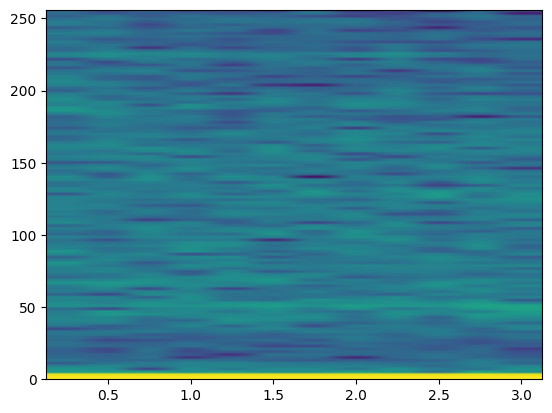

In [45]:
wav = load_call(os.path.join(DATASET_PATH, df.iloc[1]["Begin File"]), df.iloc[1]["Begin Time (s)"], df.iloc[1]["End Time (s)"])
plt.specgram(wav.squeeze().numpy(), Fs=512)
plt.show()

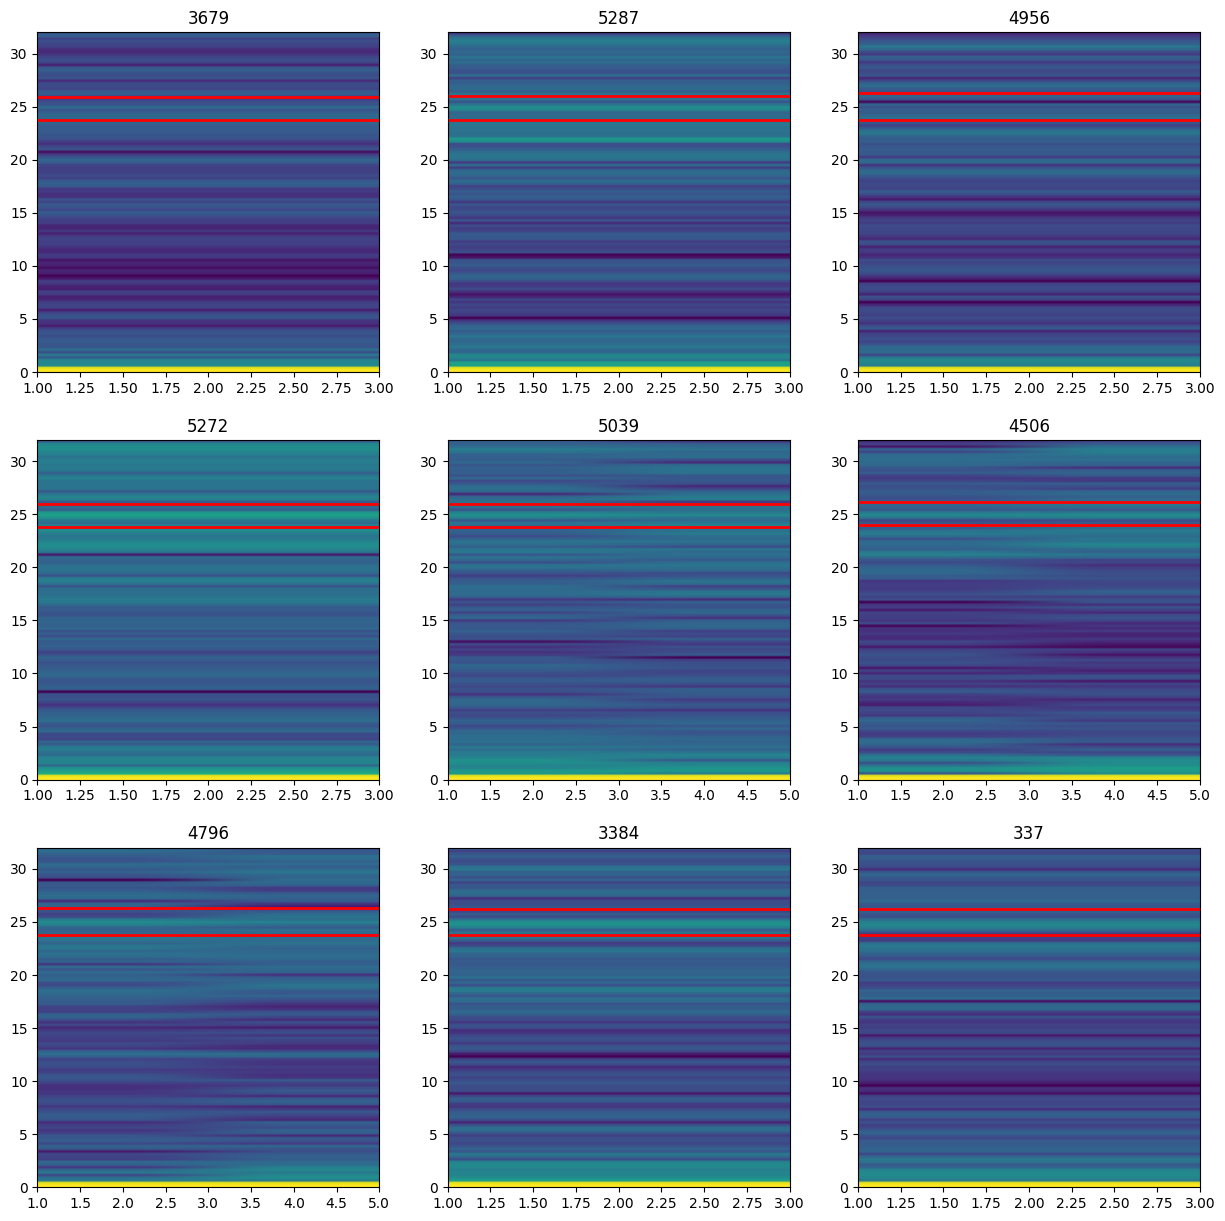

In [73]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))
target_sr = 2 ** 6
for i in range(9):
    idx = np.random.choice(df.shape[0])
    wav = load_call(os.path.join(DATASET_PATH, df.iloc[idx]["Begin File"]),
                    df.iloc[idx]["Begin Time (s)"],
                    df.iloc[idx]["End Time (s)"],
                    target_sr=target_sr)
    axes[i // 3][i % 3].specgram(wav.squeeze().numpy(), Fs=target_sr, NFFT=256, noverlap=128)
    axes[i // 3][i % 3].set_title(str(idx))  # add the species name

    # Add a rectangle for the frequency band
    low_freq = df.iloc[idx]["Low Freq (Hz)"]
    high_freq = df.iloc[idx]["High Freq (Hz)"]
    duration = (df.iloc[idx]["End Time (s)"]) - (df.iloc[idx]["Begin Time (s)"])
    
    rect = patches.Rectangle(
        (0, low_freq),  # Bottom-left corner (time=0, low frequency)
        duration,       # Width (duration of the spectrogram)
        high_freq - low_freq,  # Height (frequency range)
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    axes[i // 3][i % 3].add_patch(rect)

plt.show()